In [ ]:
from fastcore.test import *
from IPython.display import Markdown, YouTubeVideo
from manim import *
import numpy as np
from scipy.signal import convolve2d
from sympy import (
    Add,
    Derivative,
    Expr,
    Function,
    Indexed,
    IndexedBase,
    latex,
    Mul,
    Symbol,
    symbols,
)
from typing import Dict, List, Tuple

In [ ]:
config.media_embed = True

# Convolution Algorithm

Below is the convolution* function I implemented for my CNN course. It's probably not the most efficient implementation, but writing it was a good learning exercise. 

>\*I'm aware that, mathematically speaking, what I'm implementing here is actually *cross-correlation* rather than convolution. But this is what deep-learning practitioners call convolution, so I'm going with it. [This article](https://towardsdatascience.com/convolution-vs-correlation-af868b6b4fb5) offers a good description of the differences. tl;dr: in true mathematical convolution, you're supposed to flip the kernel 180° before applying it.

In [ ]:
def convolve(X: np.ndarray, filter: np.ndarray, zero_pad_width: int, stride: int):
    X_pad = np.pad(
        X,
        ((zero_pad_width, zero_pad_width), (zero_pad_width, zero_pad_width)),
        mode='constant',
        constant_values=(0.0, 0.0),
    )

    in_H, in_W = X.shape
    f, f = filter.shape

    out_H = int((in_H + (2 * zero_pad_width) - f) / stride) + 1
    out_W = int((in_W + (2 * zero_pad_width) - f) / stride) + 1

    output = np.zeros((out_H, out_W), dtype=X.dtype)

    for out_row in range(out_H):
        for out_col in range(out_W):
            in_start_row = out_row * stride
            in_start_col = out_col * stride
            output[out_row][out_col] = sum(
                (
                    X_pad[in_row][in_col] * filter[i][j]
                    for i, in_row in enumerate(range(in_start_row, in_start_row + f))
                    for j, in_col in enumerate(range(in_start_col, in_start_col + f))
                )
            )

    return output

We can test it with some sample data.

In [ ]:
X_test = np.array(
    [
        [1.0, 2.0, 3.0, 4.0,],
        [1.0, 2.0, 3.0, 4.0,],
        [1.0, 2.0, 3.0, 4.0,],
        [1.0, 2.0, 3.0, 4.0,],
    ]
)


f_test = np.array(
    [
        [0.0, 1.0,],
        [1.0, 0.0,],
    ]
)

expected = np.array(
    [
        [3.0, 5.0, 7.0], 
        [3.0, 5.0, 7.0], 
        [3.0, 5.0, 7.0]
    ]
)

test_eq(convolve(X_test, f_test, 0, 1), expected)

In [ ]:
# Test output of our convolve function is consistent with scipy
test_eq(
    convolve(X_test, f_test, 0, 1), # ours
    convolve2d(X_test, f_test, mode='valid') # scipy
)

# Convolution with Symbols
It turns out, the same convolution code works just as well when the contents of the input arrays are symbols instead of numbers. We can use the symbolic expression library, [SymPy](https://www.coursera.org/specializations/deep-learning), to represent symbols.

In [ ]:
X_test = np.array([
    [Symbol(r'x_{11}'), Symbol(r'x_{12}'), Symbol(r'x_{13}'), Symbol(r'x_{14}'),],
    [Symbol(r'x_{21}'), Symbol(r'x_{22}'), Symbol(r'x_{23}'), Symbol(r'x_{24}'),],
    [Symbol(r'x_{31}'), Symbol(r'x_{32}'), Symbol(r'x_{33}'), Symbol(r'x_{34}'),],
    [Symbol(r'x_{41}'), Symbol(r'x_{42}'), Symbol(r'x_{43}'), Symbol(r'x_{44}'),],
])


f_test = np.array([
    [Symbol(r'w_{11}'), Symbol(r'w_{12}'),],
    [Symbol(r'w_{21}'), Symbol(r'w_{22}')],
])
result = convolve(X_test, f_test, 0, 1)
result

array([[w_{11}*x_{11} + w_{12}*x_{12} + w_{21}*x_{21} + w_{22}*x_{22},
        w_{11}*x_{12} + w_{12}*x_{13} + w_{21}*x_{22} + w_{22}*x_{23},
        w_{11}*x_{13} + w_{12}*x_{14} + w_{21}*x_{23} + w_{22}*x_{24}],
       [w_{11}*x_{21} + w_{12}*x_{22} + w_{21}*x_{31} + w_{22}*x_{32},
        w_{11}*x_{22} + w_{12}*x_{23} + w_{21}*x_{32} + w_{22}*x_{33},
        w_{11}*x_{23} + w_{12}*x_{24} + w_{21}*x_{33} + w_{22}*x_{34}],
       [w_{11}*x_{31} + w_{12}*x_{32} + w_{21}*x_{41} + w_{22}*x_{42},
        w_{11}*x_{32} + w_{12}*x_{33} + w_{21}*x_{42} + w_{22}*x_{43},
        w_{11}*x_{33} + w_{12}*x_{34} + w_{21}*x_{43} + w_{22}*x_{44}]],
      dtype=object)

Each element of the output array is an _expression_ in terms of the input symbols that defines how that element is calculated. We can pretty-print the first-one to see it better:

In [ ]:
result[0][0]

w_{11}*x_{11} + w_{12}*x_{12} + w_{21}*x_{21} + w_{22}*x_{22}

This is exactly the expression for the first element of the convolution output. If you overlaid the filter on the top-left corner of the input matrix and then multipled elements and summed the products, this is the expression you'd get. By running the convolution function against symbols, we've been able to get the expressions that represent the convolution output. 

Before continuing, I want to make one improvement to the way we're creating the matrices of symbols. In the code above, I created each `Symbol` in the matrices manually. Obviously, a couple of nested `for`-loops would accomplish this with less typing. 

But beyond that, notice that each symbol name contains its row and column index. SymPy actually has support for the concept of an [Indexed Object](https://docs.sympy.org/latest/modules/tensor/indexed.html#module-sympy.tensor.indexed) that makes it a little easier to extract the indices later when doing reflection. So I created a helper function that creates arrays of indexed symbols:

In [ ]:
def ndarray_of_indexed_base(
    ib: IndexedBase, shape: Tuple[int, int], transform=lambda x: x
) -> np.ndarray:
    rows, cols = shape
    data = [
        [transform(ib[i, j]) for j in range(1, cols + 1)] for i in range(1, rows + 1)
    ]
    return np.array(data, dtype=object)

With this helper, I can create the equivalent of the `X_test` matrix above with just one line:

In [ ]:
X_test = ndarray_of_indexed_base(IndexedBase('x'), (4, 4))
X_test

array([[x[1, 1], x[1, 2], x[1, 3], x[1, 4]],
       [x[2, 1], x[2, 2], x[2, 3], x[2, 4]],
       [x[3, 1], x[3, 2], x[3, 3], x[3, 4]],
       [x[4, 1], x[4, 2], x[4, 3], x[4, 4]]], dtype=object)

The representation looks a little different but it's essentially still a matrix of symbols. Let's create a little helper function to display matrices like this in a more readable format:

In [ ]:
def matrix_to_markdown(matrix: np.ndarray) -> str:
    h, w = matrix.shape
    elements = (r'\\' + '\n').join([' & '.join([latex(matrix[i][j]) for j in range(w)]) for i in range(h)])

    markdown = '$$' r'\begin{bmatrix}' + '\n'+ elements + r'\end{bmatrix}' + '\n' '$$'
    return markdown

In [ ]:
Markdown(matrix_to_markdown(X_test))

$$\begin{bmatrix}
{x}_{1,1} & {x}_{1,2} & {x}_{1,3} & {x}_{1,4}\\
{x}_{2,1} & {x}_{2,2} & {x}_{2,3} & {x}_{2,4}\\
{x}_{3,1} & {x}_{3,2} & {x}_{3,3} & {x}_{3,4}\\
{x}_{4,1} & {x}_{4,2} & {x}_{4,3} & {x}_{4,4}\end{bmatrix}
$$

The reason we want to use Indexed Objects for our symbols is that it's easier to extract the indices and the name of the "base" (the thing being indexed):

In [ ]:
# Test accessing the indices (note that we use zero-based indices to access 
# the array but the conceptual matrix indices are 1-based.)
test_eq(X_test[0][0].indices, (1, 1))

# Test getting the name of the base. 
test_eq(X_test[0][0].base.name, 'x')

The ability to easily pull out the base name and indices of a symbol will come in handy later when we analyze expressions. 

# Example from a Convolutional Neural Network

Let's assume we've got a convolutional layer, somewhere in the middle of a CNN. To make things simple, I imagined the second layer of a CNN ($\mathcal{l} = 2$) and that I'd be dealing with:
* the activations from the previous layer, $a^{[1]}$
* the weights for the convolution kernel in the current layer, $W^{[2]}$
* the bias for the current layer, $b^{[2]}$
* the output from the convolution operation and adding the bias, $z^{[2]}$

For simplicity, I'm assuming $a^{[1]}$ has just one channel, there's just a single $W^{[2]}$ filter, and we're looking at just a single training example.

In the forward pass, $z^{[2]}$ would go through an activation function to produce $a^{[2]}$, which would then propagate through subsequent layers, and ultimately produce an output, $\hat{y}$. 

In fact, the forward pass calculation of $z^{[2]}$ for our layer of interest can now be represented with the following few lines of code:

In [ ]:
a1 = ndarray_of_indexed_base(IndexedBase(r'a^{[1]}'), (6, 6))
W2 = ndarray_of_indexed_base(IndexedBase(r'W^{[2]}'), (3, 3))
b2 = symbols(r'b^{[2]}')
z2 = convolve(a1, W2, 0, 1) + b2

We can examine the elements of `z2` to see that they represent the expressions we'd expect. E.g., the first element is:

In [ ]:
z2[0][0]

b^{[2]} + W^{[2]}[1, 1]*a^{[1]}[1, 1] + W^{[2]}[1, 2]*a^{[1]}[1, 2] + W^{[2]}[1, 3]*a^{[1]}[1, 3] + W^{[2]}[2, 1]*a^{[1]}[2, 1] + W^{[2]}[2, 2]*a^{[1]}[2, 2] + W^{[2]}[2, 3]*a^{[1]}[2, 3] + W^{[2]}[3, 1]*a^{[1]}[3, 1] + W^{[2]}[3, 2]*a^{[1]}[3, 2] + W^{[2]}[3, 3]*a^{[1]}[3, 3]

This is exactly the sum of the weights multiplied by the corresponding elements in the left corner of the input matrix, plus the bias term. Similarly, the next element of `z2` contains the expression for the next convolution output (notice the $a^{[1]}$ column indices are shifted over by one):

In [ ]:
z2[0][1]

b^{[2]} + W^{[2]}[1, 1]*a^{[1]}[1, 2] + W^{[2]}[1, 2]*a^{[1]}[1, 3] + W^{[2]}[1, 3]*a^{[1]}[1, 4] + W^{[2]}[2, 1]*a^{[1]}[2, 2] + W^{[2]}[2, 2]*a^{[1]}[2, 3] + W^{[2]}[2, 3]*a^{[1]}[2, 4] + W^{[2]}[3, 1]*a^{[1]}[3, 2] + W^{[2]}[3, 2]*a^{[1]}[3, 3] + W^{[2]}[3, 3]*a^{[1]}[3, 4]

If we wanted to visualize this expression, one way to do it would be to draw the three matrices, $a^{[1]}$, $W^{[2]}$, and $z^{[2]}$, and highlight the elements of $a^{[1]}$ and $W^{[2]}$ that are multiplied together to produce a given element of $z^{[2]}$. The code below uses [Manim](https://www.manim.community/) to render this visualization and highlights the cells corresponding to the above expression. Ignore most of the code - it's just drawing boilerplate. In the cell below, I'll highlight the parts of interest.

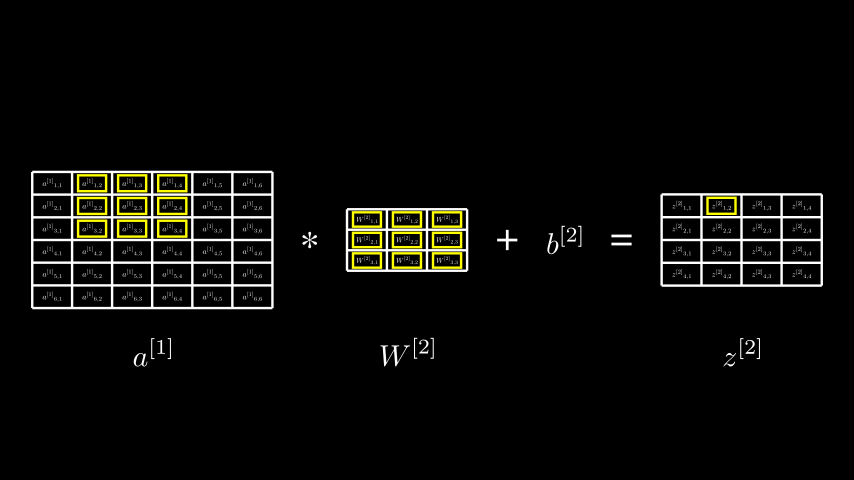

In [ ]:
%%manim -v WARNING --progress_bar None -ql -s --disable_caching HardCodedHighlights

class HardCodedHighlights(Scene):
    def construct(self):
        # Construct matrices and do the convolution
        a1 = ndarray_of_indexed_base(IndexedBase(r'a^{[1]}'), (6, 6))
        W2 = ndarray_of_indexed_base(IndexedBase(r'W^{[2]}'), (3, 3))
        b2 = symbols(r'b^{[2]}')
        z2 = convolve(a1, W2, 0, 1) + b2

        # Turn latex() into a ufunc
        latex_ufunc = np.frompyfunc(latex, 1, 1)


        # a1 matrix
        a1_view = MathTable(latex_ufunc(a1), include_outer_lines=True)
        a1_view.width = 4

        a1_h, a1_w = a1.shape

        cell_height = a1_view.height / a1_h
        cell_width = a1_view.width / a1_w

        # conv symbol
        conv_sym = Text('*')

        # W2 matrix
        W2_view = MathTable(latex_ufunc(W2), include_outer_lines=True)
        W2_h, W2_w = W2.shape
        W2_view.height = W2_h * cell_height
        W2_view.width = W2_w * cell_width

        # plus symbol
        plus_sym = Text('+')

        # bias text
        b2_view = MathTex(r'b^{[2]}')

        # equals symbol
        eq_sym = Text('=')

        # z2 matrix
        z2_view = MathTable(
            latex_ufunc(ndarray_of_indexed_base(IndexedBase(r'z^{[2]}'), z2.shape)),
            include_outer_lines=True,
        )
        z2_h, z2_w = z2.shape
        z2_view.height = z2_h * cell_height
        z2_view.width = z2_w * cell_width

        items = [a1_view, conv_sym, W2_view, plus_sym, b2_view, eq_sym, z2_view]
        g = Group(*items).arrange_in_grid(rows=1, cols=len(items), buff=0.5)
        self.add(g)

        # Labels
        a1_label = MathTex(r'a^{[1]}')
        a1_label.next_to(a1_view, direction=DOWN, buff=0.5)
        self.add(a1_label)

        W2_label = MathTex(r'W^{[2]}')
        W2_label.next_to(W2_view, direction=DOWN)
        W2_label.align_to(a1_label, DOWN)
        self.add(W2_label)

        z2_label = MathTex(r'z^{[2]}')
        z2_label.next_to(z2_view, direction=DOWN)
        z2_label.align_to(a1_label, DOWN)
        self.add(z2_label)

        # Map ndarrays to views
        array_to_view_map = {
            r'a^{[1]}': a1_view,
            r'W^{[2]}': W2_view,
            r'z^{[2]}': z2_view,
        }

        # Map of cells to highlight
        highlights_map = {
            r'W^{[2]}': [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)], 
            r'a^{[1]}': [(1, 2), (1, 3), (1, 4), (2, 2), (2, 3), (2, 4), (3, 2), (3, 3), (3, 4)],
        }

        # Highlight cells in the highlight map
        for matrix, cell_list in highlights_map.items():
            view = array_to_view_map[matrix]
            for cell in cell_list:
                highlight = view.get_cell(cell, color=YELLOW).scale(0.7)
                self.add(highlight)

        # Highlight the output cell
        self.add(z2_view.get_cell((1, 2), color=YELLOW).scale(0.7))

In the code above, we hardcoded the cells to highlight:

```python
        # Map of cells to highlight
        highlights_map = {
            r'W^{[2]}': [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)], 
            r'a^{[1]}': [(1, 2), (1, 3), (1, 4), (2, 2), (2, 3), (2, 4), (3, 2), (3, 3), (3, 4)],
        }
```

It would be better if we could generate this highlights map directly from an expression like:

$$
{W^{[2]}}_{1,1} {a^{[1]}}_{1,2} + {W^{[2]}}_{1,2} {a^{[1]}}_{1,3} + {W^{[2]}}_{1,3} {a^{[1]}}_{1,4} + {W^{[2]}}_{2,1} {a^{[1]}}_{2,2} + {W^{[2]}}_{2,2} {a^{[1]}}_{2,3} + {W^{[2]}}_{2,3} {a^{[1]}}_{2,4} + {W^{[2]}}_{3,1} {a^{[1]}}_{3,2} + {W^{[2]}}_{3,2} {a^{[1]}}_{3,3} + {W^{[2]}}_{3,3} {a^{[1]}}_{3,4}
$$

This turns out to be pretty easy to do. The key to doing this is that SymPy represents expressions in easily navigable tree structures. Details are in the [documentation](https://docs.sympy.org/latest/tutorials/intro-tutorial/manipulation.html) but the basic idea is that every expression object has a `func` attribute and an `args` attribute that (roughly) correspond to the operation and operands respectively. A few examples:

In [ ]:
x = Symbol('x')
expr = 2 + x

# The expressions's `func` is Add
test_eq(expr.func, Add)

# It's `args` are 2 and x
test_eq(expr.args, (2, x))

Using `func` and `args` to reflect over expressions, we can write a function that takes an expression and returns a dictionary where the keys are matrix names, and the values are lists of indices to highlight. 

In [ ]:
def build_highlights_map(expr: Expr) -> Dict[str, List[Tuple]]:
    # The expression needs to be either a sum of products or a single product
    assert expr.func == Add or expr.func == Mul

    # If it's an Add, assert all args are Muls
    if expr.func == Add:
        assert all(arg.func == Mul for arg in expr.args)

    # We want the list of multiplications. This is either a list consisting
    # of just the expression itself if it's a Mul or its arguments if it's
    # an Add.
    muls = [expr] if expr.func == Mul else expr.args

    results = {}
    for expr in muls:
        # Assert all the args are Indexed
        assert all(arg.func == Indexed for arg in expr.args)

        for indexed in expr.args:
            if indexed.base.name not in results:
                results[indexed.base.name] = []
            results[indexed.base.name].append(indexed.indices)    
    return results

This function makes a lot of assumptions that it's dealing with expressions that are just sums of products of `Indexed` objects, but it suffices for what we need. We can test it with one of our expressions in the `z2` array:

In [ ]:
build_highlights_map(z2[0][1]-b2) # Subtract off b2 because we aren't interested in the bias term for now.

{'W^{[2]}': [(1, 1),
  (1, 2),
  (1, 3),
  (2, 1),
  (2, 2),
  (2, 3),
  (3, 1),
  (3, 2),
  (3, 3)],
 'a^{[1]}': [(1, 2),
  (1, 3),
  (1, 4),
  (2, 2),
  (2, 3),
  (2, 4),
  (3, 2),
  (3, 3),
  (3, 4)]}

Now, we can incorporate that into a Manim scene and add some animation to go through all of the expressions in `z2`.

In [ ]:
%%manim -v WARNING --progress_bar None -ql --disable_caching ConvolutionForward

class ConvolutionForward(Scene):
    def construct(self):
        # Construct matrices and do the convolution
        a1 = ndarray_of_indexed_base(IndexedBase(r'a^{[1]}'), (6, 6))
        W2 = ndarray_of_indexed_base(IndexedBase(r'W^{[2]}'), (3, 3))
        b2 = symbols(r'b^{[2]}')
        z2 = convolve(a1, W2, 0, 1) + b2

        # Turn latex() into a ufunc
        latex_ufunc = np.frompyfunc(latex, 1, 1)


        # a1 matrix
        a1_view = MathTable(latex_ufunc(a1), include_outer_lines=True)
        a1_view.width = 4

        a1_h, a1_w = a1.shape

        cell_height = a1_view.height / a1_h
        cell_width = a1_view.width / a1_w

        # conv symbol
        conv_sym = Text('*')

        # W2 matrix
        W2_view = MathTable(latex_ufunc(W2), include_outer_lines=True)
        W2_h, W2_w = W2.shape
        W2_view.height = W2_h * cell_height
        W2_view.width = W2_w * cell_width

        # plus symbol
        plus_sym = Text('+')

        # bias text
        b2_view = MathTex(r'b^{[2]}')

        # equals symbol
        eq_sym = Text('=')

        # z2 matrix
        z2_view = MathTable(
            latex_ufunc(ndarray_of_indexed_base(IndexedBase(r'z^{[2]}'), z2.shape)),
            include_outer_lines=True,
        )
        z2_h, z2_w = z2.shape
        z2_view.height = z2_h * cell_height
        z2_view.width = z2_w * cell_width

        items = [a1_view, conv_sym, W2_view, plus_sym, b2_view, eq_sym, z2_view]
        g = Group(*items).arrange_in_grid(rows=1, cols=len(items), buff=0.5)
        self.add(g)

        # Labels
        a1_label = MathTex(r'a^{[1]}')
        a1_label.next_to(a1_view, direction=DOWN, buff=0.5)
        self.add(a1_label)

        W2_label = MathTex(r'W^{[2]}')
        W2_label.next_to(W2_view, direction=DOWN)
        W2_label.align_to(a1_label, DOWN)
        self.add(W2_label)

        z2_label = MathTex(r'z^{[2]}')
        z2_label.next_to(z2_view, direction=DOWN)
        z2_label.align_to(a1_label, DOWN)
        self.add(z2_label)

        # Map ndarrays to views
        array_to_view_map = {
            r'a^{[1]}': a1_view,
            r'W^{[2]}': W2_view,
            r'z^{[2]}': z2_view,
        }

        # Some config knobs for the animations
        FADE_IN_TIME = 0.5
        FADE_OUT_TIME = 0.3
        WAIT_TIME = 0.5

        # Build highlight map for all elements of z2
        build_highlights_map_ufunc = np.frompyfunc(build_highlights_map, 1, 1)
        highlights_map = build_highlights_map_ufunc(z2-b2)

        # Go through each highlights map and do the animations
        h, w = z2.shape
        for i in range(h):
            for j in range(w):
                highlight = z2_view.get_cell((i + 1, j + 1), color=YELLOW).scale(
                    0.7
                )
                anims_in = [FadeIn(highlight, run_time=FADE_IN_TIME)]
                anims_out = [FadeOut(highlight, run_time=FADE_OUT_TIME)]

                for matrix, cell_list in highlights_map[i][j].items():
                    view = array_to_view_map[matrix]
                    for cell in cell_list:
                        highlight = view.get_cell(cell, color=YELLOW).scale(0.7)

                        anims_in.append(FadeIn(highlight, run_time=FADE_IN_TIME))
                        anims_out.append(FadeOut(highlight, run_time=FADE_IN_TIME))


                self.play(*anims_in)
                self.wait(WAIT_TIME)
                self.play(*anims_out)



This produces a video. To keep the notebook small, I've not embedded it directly, but the YouTube version below shows the output. This is a working animation of a convolution, generated directly from the expressions. 

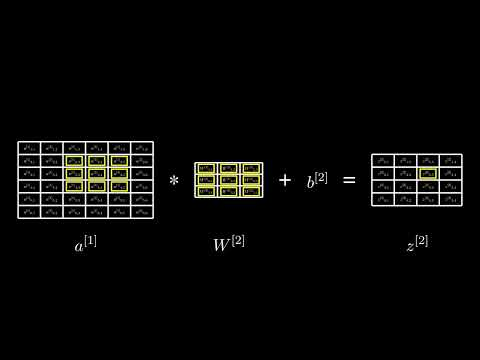

In [ ]:
YouTubeVideo('DrYgzmsFaNM', allow_autoplay=True, loop=True)

# Backprop through Convolutions

The calculation of $z^{[2]}$ we've looked at so far is part of the forward pass of a CNN. As I mentioned before, $z^{[2]}$ will typically go through a non-linear activation function to produce $a^{[2]}$, which would propagate all the way to the end of the network, producing a final output, $\hat{y}$. 

To start the backward pass, we'd evaluate the loss function ($\mathcal{L}(y, \hat{y})$) and use the chain rule to propagate the loss backwards through the layers. My CNN class didn't derive the backprop equations for convolutional layers - my attempting to do that on my own led to this whole investigation. It turns out that the approach of using symbols in the convolution matrices makes it really easy to not only derive the backprop equations but also visualize them. 

As a starting point, I'll assume the backprop process has given us $\frac{\partial \mathcal{L}}{\partial z^{[2]}}$ and now need to compute $\frac{\partial \mathcal{L}}{\partial W^{[2]}}$, $\frac{\partial \mathcal{L}}{\partial b^{[2]}}$, and $\frac{\partial \mathcal{L}}{\partial a^{[1]}}$.

Let's start with the simplest one, $\frac{\partial \mathcal{L}}{\partial b^{[2]}}$: the gradient of the loss with respect to the bias term, $b^{[2]}$. 

## Deriving $\frac{\partial \mathcal{L}}{\partial b^{[2]}}$

We calculated $z^{[2]}$ as follows:

$$
z^{[2]} = a^{[1]} * W^{[2]} + b^{[2]}
$$

$b^{[2]}$ is a scalar that we add to each element of the matrix, $a^{[1]} * W^{[2]}$. For the purpose of this derivation, it's helpful to think of $b^{[2]}$ as a matrix with the same dimensions as $a^{[1]} * W^{[2]}$ in which the value of every element is the scalar value of $b^{[2]}$:

$$
\begin{bmatrix}
b^{[2]} & b^{[2]} & b^{[2]} & b^{[2]}\\
b^{[2]} & b^{[2]} & b^{[2]} & b^{[2]}\\
b^{[2]} & b^{[2]} & b^{[2]} & b^{[2]}\\
b^{[2]} & b^{[2]} & b^{[2]} & b^{[2]}\\
\end{bmatrix}
$$

To distinguish the scalar $b^{[2]}$ clearly from the matrix version, we'll call the matrix version $\mathbf{B^{[2]}}$:

$$
\mathbf{B^{[2]}} = 
\def\arraystretch{1.5}
\begin{bmatrix}
\mathbf{B^{[2]}_{11}} & \mathbf{B^{[2]}_{12}} & \mathbf{B^{[2]}_{13}} & \mathbf{B^{[2]}_{14}}\\
\mathbf{B^{[2]}_{21}} & \mathbf{B^{[2]}_{22}} & \mathbf{B^{[2]}_{23}} & \mathbf{B^{[2]}_{24}}\\
\mathbf{B^{[2]}_{31}} & \mathbf{B^{[2]}_{32}} & \mathbf{B^{[2]}_{33}} & \mathbf{B^{[2]}_{34}}\\
\mathbf{B^{[2]}_{41}} & \mathbf{B^{[2]}_{42}} & \mathbf{B^{[2]}_{43}} & \mathbf{B^{[2]}_{44}}\\
\end{bmatrix}
=
\begin{bmatrix}
b^{[2]} & b^{[2]} & b^{[2]} & b^{[2]}\\
b^{[2]} & b^{[2]} & b^{[2]} & b^{[2]}\\
b^{[2]} & b^{[2]} & b^{[2]} & b^{[2]}\\
b^{[2]} & b^{[2]} & b^{[2]} & b^{[2]}\\
\end{bmatrix}
$$

and 

$$
z^{[2]} = a^{[1]} * W^{[2]} + \mathbf{B^{[2]}}
$$
Now the plus sign in the formular above is just plain matrix (element-wise) addition.

>Note: The transformation from $b^{[2]}$ to $\mathbf{B^{[2]}}$ I've written out here actually happens implicitly in the code we wrote earlier (`z2 = convolve(a1, W2, 0, 1) + b2`) because of [NumPy broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html).

We can then calculate the derivative of $\mathcal{L}$ with respect to this $\mathbf{B^{[2]}}$ matrix. Remember, we've got $\frac{\partial \mathcal{L}}{\partial z^{[2]}}$ and now we want $\frac{\partial \mathcal{L}}{\partial \mathbf{B^{[2]}}}$. 

We can do this by applying the chain rule, element-wise. E.g. $\frac{\partial \mathcal{L}}{\partial \mathbf{B^{[2]_{11}}}}$ would be:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{B^{[2]_{11}}}} = \frac{\partial \mathcal{L}}{\partial z^{[2]_{11}}}\frac{\partial z^{[2]_{11}}}{\partial \mathbf{B^{[2]_{11}}}} + \frac{\partial \mathcal{L}}{\partial z^{[2]_{12}}}\frac{\partial z^{[2]_{12}}}{\partial \mathbf{B^{[2]_{11}}}} + \cdots + \frac{\partial \mathcal{L}}{\partial z^{[2]_{44}}}\frac{\partial z^{[2]_{44}}}{\partial \mathbf{B^{[2]_{11}}}} 
$$

We could take this further and simply by hand to work out what this is really saying, but we've got a whole symbolic engine at our disposal so let's use that instead. 


First, let's write a general function to do the element-wise chain rule operation described above. Assuming `A`, and `B` are matrices of symbols and `df_dA` is also a matrix of symbols representing $\frac{\partial f}{\partial A}$, this function computes $\frac{\partial f}{\partial B}$ by applying the chain rule element-wise:

For every $i, j$ in $B$, the function calculates 

$$
\frac{\partial f}{\partial B_{i, j}} = \sum_{k, l} \frac{\partial f}{\partial A_{k, l}}\frac{\partial A_{k, l}}{\partial B_{i, j}}
$$

Most of the function is just `for`-loops and summing, but the interesting part is that it uses [SymPy's calculus abilities](https://docs.sympy.org/latest/tutorials/intro-tutorial/calculus.html) to compute $\frac{\partial A_{k, l}}{\partial B_{i, j}}$ symbolically in the line:

```python
df_dA[ak][al] * A[ak][al].diff(B[bi][bj])
```

In [ ]:
def matrix_matrix_chain_rule(df_dA: np.ndarray, A: np.ndarray, B: np.ndarray):
    """
    Say f is a function, A & B are matrices represented by ndarrays
    Given an matrix of the elements of df/dA, A, and B, this function
    computes the elements of df_dB by applying the chain rule element-
    wise.
    """
    Ah, Aw = A.shape
    Bh, Bw = B.shape

    output = np.zeros(B.shape, dtype=B.dtype)

    for bi in range(Bh):
        for bj in range(Bw):
            output[bi][bj] = sum(
                [
                    df_dA[ak][al] * A[ak][al].diff(B[bi][bj])
                    for ak in range(Ah)
                    for al in range(Aw)
                ]
            )

    return output


We can now use this to calculate $\frac{\partial \mathcal{L}}{\partial \mathbf{B^{[2]}}}$:

In [ ]:
# Create a1, W2, and convolve them:
a1 = ndarray_of_indexed_base(IndexedBase(r'a^{[1]}'), (6, 6))
W2 = ndarray_of_indexed_base(IndexedBase(r'W^{[2]}'), (3, 3))
conv_result = convolve(a1, W2, 0, 1)

# Set up B2 with the same shape as conv_result
B2 = ndarray_of_indexed_base(IndexedBase(r'B^{[2]}'), conv_result.shape)

# Calculate z2 in terms of the conv_result and B2.
z2 = conv_result + B2

# Set up the loss function symbolically.
y = symbols('y')
yhat = symbols(r'\hat{y}')
L = Function(r'\mathcal{L}')(y, yhat)

# Build dL/dz2
dz2 = ndarray_of_indexed_base(
    IndexedBase(r'z^{[2]}'), z2.shape, transform=lambda x: Derivative(L, x)
)

dB2 = matrix_matrix_chain_rule(dz2, z2, B2)

Markdown(matrix_to_markdown(dB2))

$$\begin{bmatrix}
\frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)}\\
\frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)}\\
\frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)}\\
\frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)}\end{bmatrix}
$$

Each element of this is the same as the corresponding element of $\frac{\partial \mathcal{L}}{\partial z^{[2]}}$. We can confirm that 

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{B^{[2]}}} = \frac{\partial \mathcal{L}}{\partial z^{[2]}}
$$

in code: 

In [ ]:
test_eq(dB2, dz2)